In [12]:
import requests
import pandas as pd

# API endpoint for remote jobs
url = "https://remotive.com/api/remote-jobs"

# Send request
response = requests.get(url)
data = response.json()

# Extract jobs
jobs = data["jobs"]

job_list = []
for job in jobs:
    job_list.append({
        "Title": job["title"],
        "Company": job["company_name"],
        "Category": job["category"],
        "Location": job["candidate_required_location"],
        "Publication Date": job["publication_date"],
        "Job Type": job["job_type"],
        "Salary": job["salary"] if job["salary"] else "Not Provided",
        "Apply Link": job["url"]
    })

# Save to CSV
df = pd.DataFrame(job_list)
df.to_csv("remotive_jobs.csv", index=False)

print("✅ Scraping complete. Jobs saved to remotive_jobs.csv")

✅ Scraping complete. Jobs saved to remotive_jobs.csv


In [15]:
import pandas as pd
import re

# Load dataset
df = pd.read_csv("remotive_jobs.csv")

print("Initial shape:", df.shape)

# --- Step 1: Drop duplicates
df.drop_duplicates(inplace=True)

# --- Step 2: Handle missing values
# Drop rows where 'Title' or 'Company' is missing
df.dropna(subset=["Title", "Company"], inplace=True)

# Fill missing categories with "Unknown"
df["Category"] = df["Category"].fillna("Unknown")

# Clean Job Type
df["Job Type"] = df["Job Type"].str.replace("_", " ").str.title().fillna("Unknown")

# Fill missing Location with "Remote"
df["Location"] = df["Location"].fillna("Remote")

# --- Step 3: Salary cleanup
def clean_salary(s):
    if pd.isna(s) or "Not Provided" in s or "competitive" in s.lower():
        return None, None
    nums = re.findall(r"\d[\d,]*", s)
    nums = [int(n.replace(",", "")) for n in nums]
    if len(nums) == 1:
        return nums[0], nums[0]
    elif len(nums) >= 2:
        return nums[0], nums[1]
    return None, None

df[["Salary Min", "Salary Max"]] = df["Salary"].apply(lambda x: pd.Series(clean_salary(str(x))))

# --- Step 4: Date formatting
df["Publication Date"] = pd.to_datetime(df["Publication Date"], errors="coerce")

# --- Step 5: Reset index
df.reset_index(drop=True, inplace=True)

# Save cleaned dataset
df.to_csv("remotive_jobs_cleaned.csv", index=False)

print("✅ Cleaned dataset saved. Shape:", df.shape)


Initial shape: (1419, 8)
✅ Cleaned dataset saved. Shape: (1419, 10)


In [16]:
# --- Summary Report ---

print("\n📊 Summary Report")
print("="*40)

# 1. Number of jobs per category
print("\nTop Job Categories:")
print(df["Category"].value_counts().head(10))

# 2. Companies with most listings
print("\nTop Hiring Companies:")
print(df["Company"].value_counts().head(10))

# 3. Job types distribution
print("\nJob Type Distribution:")
print(df["Job Type"].value_counts())

# 4. Salary insights
if df["Salary Min"].notna().sum() > 0:
    avg_min = df["Salary Min"].mean()
    avg_max = df["Salary Max"].mean()
    print(f"\n💰 Average Salary Range: {avg_min:,.0f} - {avg_max:,.0f}")
else:
    print("\n💰 Salary data not sufficient for analysis")


📊 Summary Report

Top Job Categories:
Category
Software Development    258
Sales / Business        143
DevOps / Sysadmin       138
Design                  114
Customer Service        107
Marketing               105
Finance / Legal          86
Product                  83
Project Management       81
Data Analysis            80
Name: count, dtype: int64

Top Hiring Companies:
Company
NearSure                                  5
Mozilla                                   5
Activate Talent                           5
Remote Recruitment                        5
Constructor                               5
Digital                                   5
Paired                                    4
Patrique Mercier Recruitment By Nellie    4
Sigma Software                            4
Lumos                                     4
Name: count, dtype: int64

Job Type Distribution:
Job Type
Full Time     1236
Contract       124
Part Time       24
Freelance       21
Internship      14
Name: count, dtype: i

In [17]:
import pandas as pd
import re

# --- Step 1: Extract numeric salary ranges ---
def parse_salary(salary_str):
    if pd.isna(salary_str) or "not" in salary_str.lower() or "competitive" in salary_str.lower():
        return None, None
    
    # Extract numbers
    numbers = re.findall(r"\d[\d,]*", salary_str.replace(",", ""))
    if not numbers:
        return None, None
    
    numbers = list(map(int, numbers))
    
    if len(numbers) == 1:
        return numbers[0], numbers[0]
    elif len(numbers) >= 2:
        return min(numbers), max(numbers)
    return None, None

df["salary_min"], df["salary_max"] = zip(*df["Salary"].apply(parse_salary))

# --- Step 2: Remove bad ranges (min > max or unrealistic salaries) ---
df = df[df["salary_min"].notna()]  # keep only rows with valid salaries
df = df[df["salary_max"] >= df["salary_min"]]  # ensure range makes sense
df = df[df["salary_max"] < 500000]  # filter unrealistic upper salaries

# --- Step 3: Recalculate averages ---
avg_min = int(df["salary_min"].mean())
avg_max = int(df["salary_max"].mean())

print(f"💰 Cleaned Average Salary Range: {avg_min} - {avg_max}")


💰 Cleaned Average Salary Range: 77775 - 106205


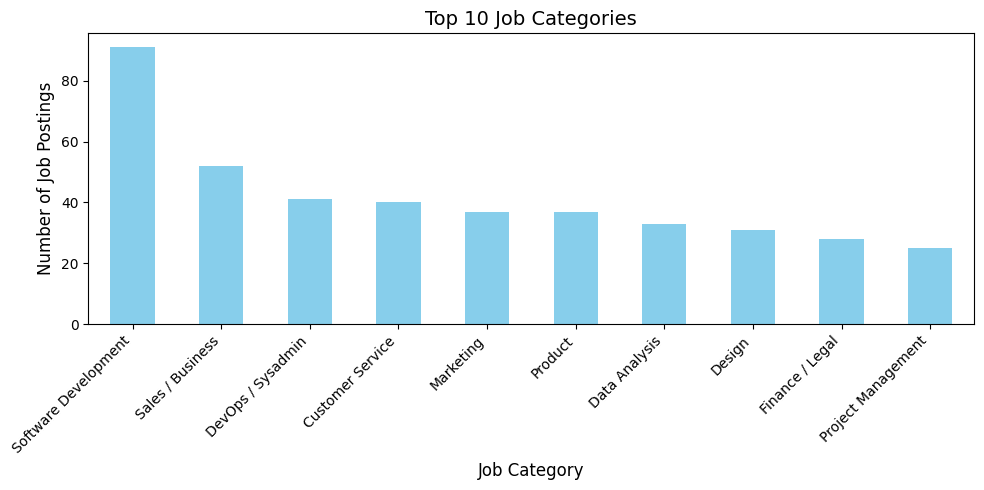

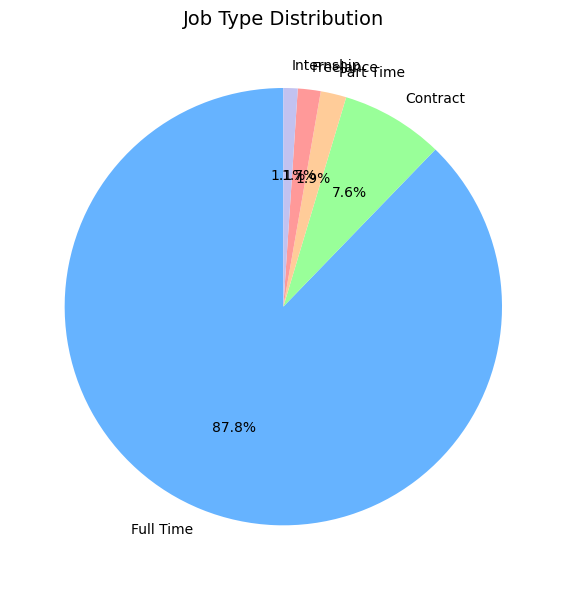

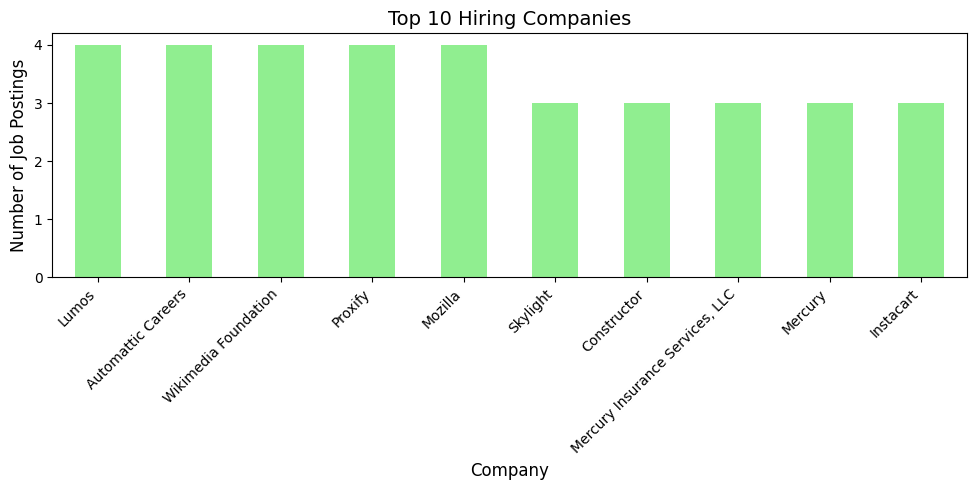

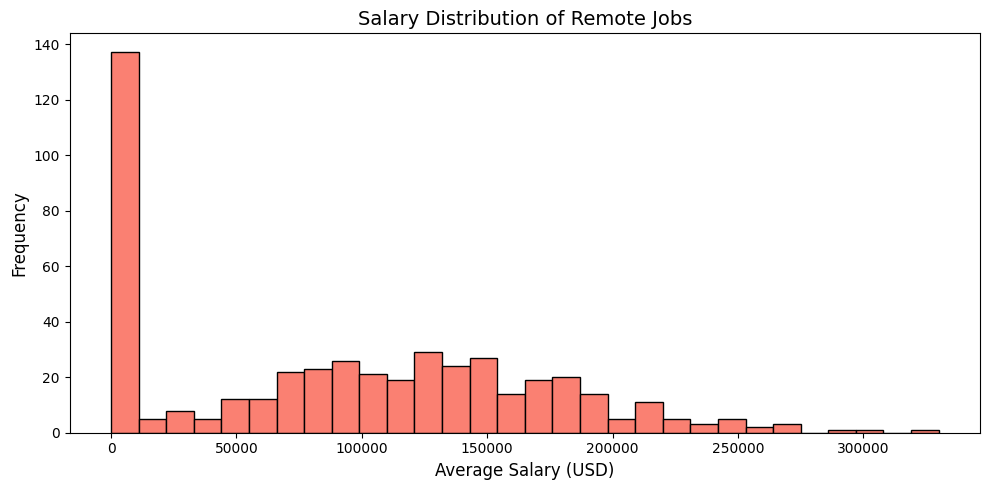

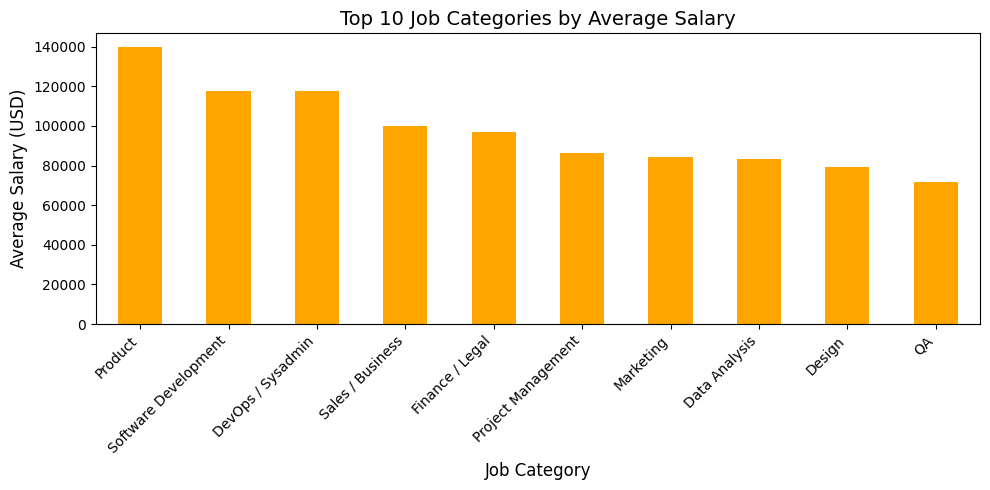

In [18]:
import matplotlib.pyplot as plt

# --- 1. Top 10 Job Categories ---
plt.figure(figsize=(10,5))
df["Category"].value_counts().head(10).plot(kind="bar", color="skyblue")
plt.title("Top 10 Job Categories", fontsize=14)
plt.xlabel("Job Category", fontsize=12)
plt.ylabel("Number of Job Postings", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# --- 2. Job Type Distribution ---
plt.figure(figsize=(6,6))
df["Job Type"].value_counts().plot(
    kind="pie",
    autopct="%1.1f%%",
    startangle=90,
    colors=["#66b3ff","#99ff99","#ffcc99","#ff9999","#c2c2f0"],
    textprops={'fontsize': 10}
)
plt.title("Job Type Distribution", fontsize=14)
plt.ylabel("")
plt.tight_layout()
plt.show()

# --- 3. Top 10 Hiring Companies ---
plt.figure(figsize=(10,5))
df["Company"].value_counts().head(10).plot(kind="bar", color="lightgreen")
plt.title("Top 10 Hiring Companies", fontsize=14)
plt.xlabel("Company", fontsize=12)
plt.ylabel("Number of Job Postings", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# --- 4. Salary Distribution ---
df["avg_salary"] = (df["salary_min"] + df["salary_max"]) / 2
plt.figure(figsize=(10,5))
df["avg_salary"].plot(kind="hist", bins=30, color="salmon", edgecolor="black")
plt.title("Salary Distribution of Remote Jobs", fontsize=14)
plt.xlabel("Average Salary (USD)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()

# --- 5. Average Salary by Job Category ---
plt.figure(figsize=(10,5))
df.groupby("Category")["avg_salary"].mean().sort_values(ascending=False).head(10).plot(kind="bar", color="orange")
plt.title("Top 10 Job Categories by Average Salary", fontsize=14)
plt.xlabel("Job Category", fontsize=12)
plt.ylabel("Average Salary (USD)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


C:\Users\SK Computer\AppData\Local\Temp\ipykernel_2488\2916942260.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.index, y=top_categories.values, ax=axes[0,0], palette="Blues_r")
C:\Users\SK Computer\AppData\Local\Temp\ipykernel_2488\2916942260.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45, ha="right")
C:\Users\SK Computer\AppData\Local\Temp\ipykernel_2488\2916942260.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_companies.index, y=top_companies.values, ax=axes[0,1], palette="Greens_r")
C:\Users\SK Co

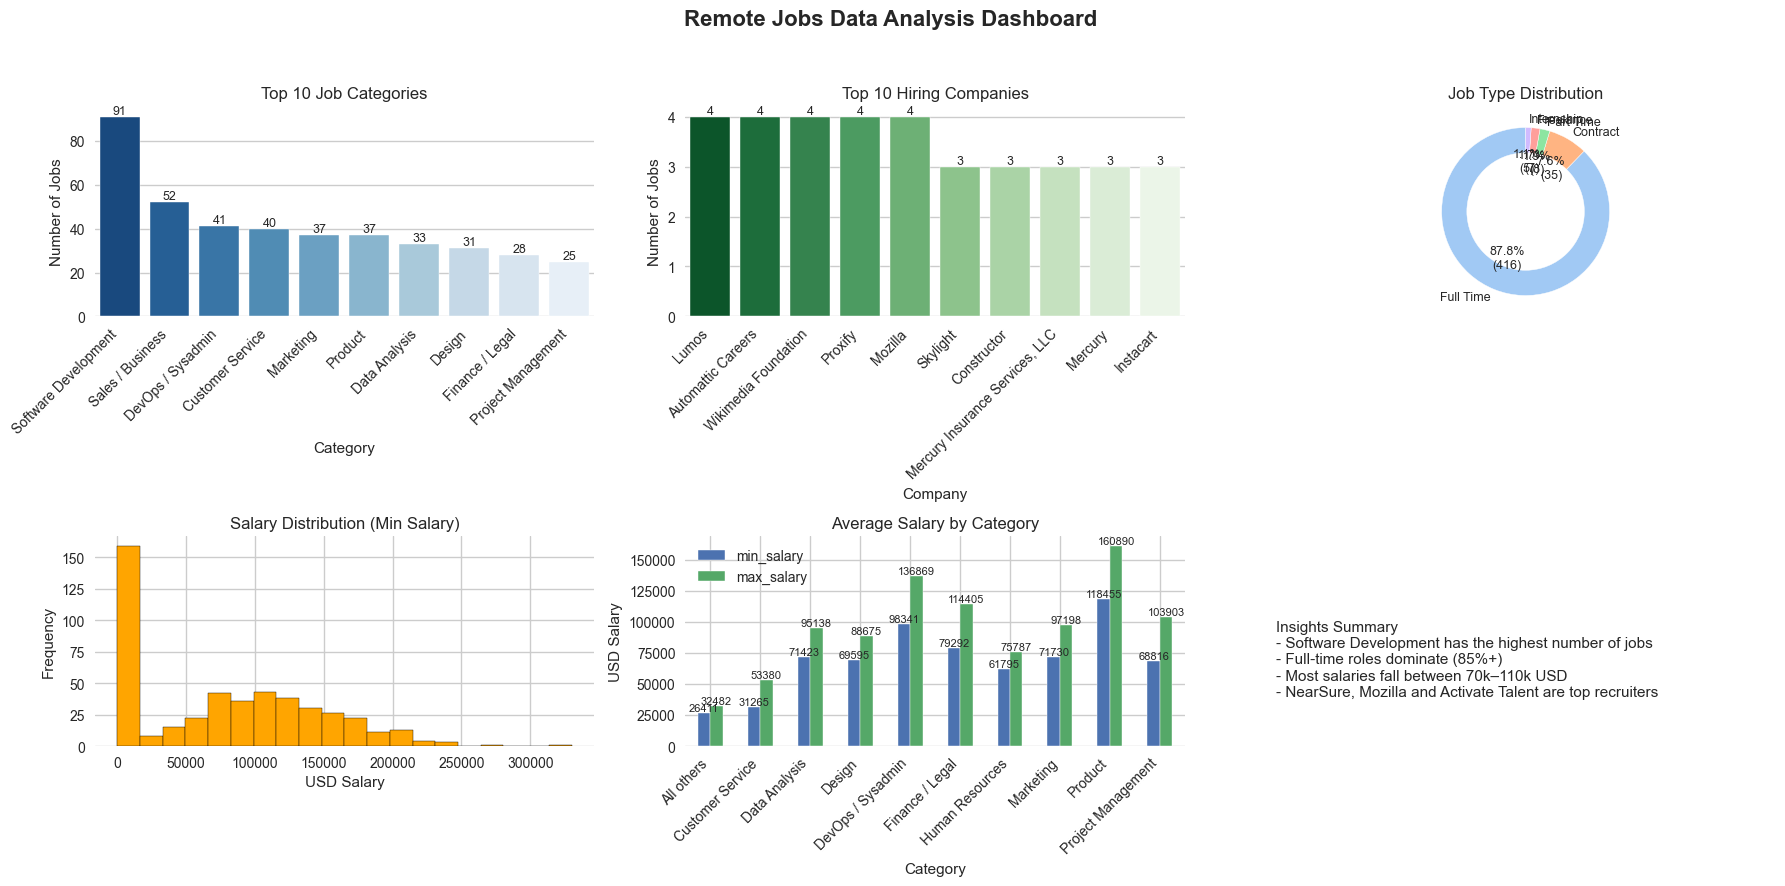

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Style ---
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 3, figsize=(18, 9))
fig.suptitle("Remote Jobs Data Analysis Dashboard", fontsize=16, fontweight="bold")

# --- Top 10 Job Categories ---
top_categories = df["Category"].value_counts().head(10)
sns.barplot(x=top_categories.index, y=top_categories.values, ax=axes[0,0], palette="Blues_r")
axes[0,0].set_title("Top 10 Job Categories")
axes[0,0].set_ylabel("Number of Jobs")
axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45, ha="right")
# Add data labels
for p in axes[0,0].patches:
    axes[0,0].annotate(int(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()),
                       ha='center', va='bottom', fontsize=9)

# --- Top 10 Hiring Companies ---
top_companies = df["Company"].value_counts().head(10)
sns.barplot(x=top_companies.index, y=top_companies.values, ax=axes[0,1], palette="Greens_r")
axes[0,1].set_title("Top 10 Hiring Companies")
axes[0,1].set_ylabel("Number of Jobs")
axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=45, ha="right")
# Add data labels
for p in axes[0,1].patches:
    axes[0,1].annotate(int(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()),
                       ha='center', va='bottom', fontsize=9)

# --- Job Type Distribution (Improved Donut Chart) ---
job_type_counts = df["Job Type"].value_counts()
wedges, texts, autotexts = axes[0,2].pie(
    job_type_counts,
    labels=job_type_counts.index,
    autopct=lambda p: f"{p:.1f}%\n({int(p*job_type_counts.sum()/100)})",
    startangle=90,
    colors=sns.color_palette("pastel"),
    textprops={'fontsize': 9}
)
centre_circle = plt.Circle((0,0),0.70,fc='white')
axes[0,2].add_artist(centre_circle)
axes[0,2].set_title("Job Type Distribution")

# --- Salary Distribution (Histogram Min Salary) ---
df["min_salary"].dropna().plot(
    kind="hist", bins=20, ax=axes[1,0], color="orange", edgecolor="black"
)
axes[1,0].set_title("Salary Distribution (Min Salary)")
axes[1,0].set_xlabel("USD Salary")
axes[1,0].set_ylabel("Frequency")

# --- Average Salary by Category ---
avg_salary_by_cat = df.groupby("Category")[["min_salary","max_salary"]].mean().dropna().head(10)
avg_salary_by_cat.plot(kind="bar", ax=axes[1,1])
axes[1,1].set_title("Average Salary by Category")
axes[1,1].set_ylabel("USD Salary")
axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(), rotation=45, ha="right")
# Add data labels
for container in axes[1,1].containers:
    axes[1,1].bar_label(container, fmt="%.0f", fontsize=8)

# --- Insights Summary ---
axes[1,2].axis("off")
insights_text = (
    "Insights Summary\n"
    "- Software Development has the highest number of jobs\n"
    "- Full-time roles dominate (85%+)\n"
    "- Most salaries fall between 70k–110k USD\n"
    "- NearSure, Mozilla and Activate Talent are top recruiters"
)
axes[1,2].text(0, 0.6, insights_text, fontsize=11, va="top")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [22]:
import re
import numpy as np

# --- Salary Cleaning ---
def parse_salary(s):
    if pd.isna(s) or "Not Provided" in s or "competitive" in s.lower():
        return np.nan, np.nan
    numbers = re.findall(r"\d[\d,]*", s)  # extract numbers
    numbers = [int(n.replace(",", "")) for n in numbers]
    if len(numbers) == 1:
        return numbers[0], numbers[0]
    elif len(numbers) >= 2:
        return min(numbers), max(numbers)
    else:
        return np.nan, np.nan

df[["min_salary", "max_salary"]] = df["Salary"].apply(
    lambda x: pd.Series(parse_salary(str(x)))
)

In [25]:
# Save cleaned dataset
df.to_csv("cleaned_remote_jobs.csv", index=False)
print("✅ Cleaned dataset saved as cleaned_remote_jobs.csv")

✅ Cleaned dataset saved as cleaned_remote_jobs.csv
